#### Introduction to Statistical Learning, Lab 3.1

# Simple Linear Regression

In the Python environment the most popular libraries for model fitting (and therefore linear regression) *sklearn* and *statsmodels*. The statsmodels library provides a R-style formula-based interface. We will mostly use this interface because it provides more flexibility and better parameter reporting. This has the additional advantage that it maps quite well onto the examples in the ISLR book.  


  - [statsmodels documentation](https://www.statsmodels.org/stable/)
  - [statsmodels formula interface](https://www.statsmodels.org/stable/example_formulas.html)
  - [the formula mini language](https://patsy.readthedocs.io/en/latest/formulas.html#the-formula-language)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from islpy import datasets
sns.set()
%matplotlib inline

#### Data Set

We use the `Boston` data set to demonstrate simple linear regression.

In [2]:
boston = datasets.Boston()
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Model Specification

The `smf.ols()` function builds a statistical *model* prepared for fitting with *ordinary least squares* (ols). This is the type of fit explained in detail in the lecture.

The formula `medv~lstat` means we are using `lstat` as our predictor and `medv` as our dependent variable:

$$ \mathrm{medv} = \beta_0 + \beta_1 \mathrm{lstat} $$

In [3]:
model = smf.ols(formula='medv~lstat', data=boston)

#### Fitting the Model

We *fit* the model to the data by calling the `fit()` method:

In [4]:
model_fit = model.fit()

#### Fit Result Summary

We can get a comprehensive summary using the `summary()` method:

In [5]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           5.08e-88
Time:                        19:01:15   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Specific Summary Tables

We can also select a specific table from the summary. For example the fitted coefficients:

In [6]:
model_fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,34.5538,0.563,61.415,0.000,33.448,35.659
lstat,-0.9500,0.039,-24.528,0.000,-1.026,-0.874


#### Fit Result Parameters

Or we can retrieve only the fitted parameters ($\beta_0$ = *intercept*, $\beta_1$ = *lstat*) as a pandas series using the `params` attribute:

In [7]:
model_fit.params

Intercept    34.553841
lstat        -0.950049
dtype: float64

#### Confidence Intervals

The 95% confidence intervals for the coefficients can be retrieved via the `conf_int()` method:

In [8]:
model_fit.conf_int()

,0,1
Intercept,33.448457,35.659225
lstat,-1.026148,-0.873951


#### Making Predictions

The purpose of fitting a model is to make predictions from as of yet unobserved predictors in the future. We use the `predict()` method to do that. Note that the predictor data set must provide all keys (column names) used in the formula. In practice this will almost always be a pandas data frame with the required columns. But any `dict`-like object with the required keys will work. 

In [9]:
model_fit.predict({'lstat': [5, 10, 15]})

0    29.803594
1    25.053347
2    20.303101
dtype: float64

#### Prediction with Confidence and Prediction Intervals

In case we need confidence and/or prediction intervals we use the `get_prediction()` method and extract a summary data frame from the result with `summary_frame()`:

In [10]:
pred = model_fit.get_prediction({'lstat': [5, 10, 15]})
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,25.053347,0.294814,24.474132,25.632563,12.827626,37.279068
2,20.303101,0.290893,19.731588,20.874613,8.077742,32.528459


The `mean_ci` columns are the confidence interval limits and the `obs_ci` columns are the prediction interval limits.

For instance, the 95% confidence interval associated with an `lstat` value of 10 is (24.47, 25.63), and the 95% prediction interval is (12.83, 37.28). As expected, they are both centred around the same point, the predicted value 25.05, but the prediction interval is substantially wider.

#### Visualising the Fit Results

Our goal is to make a graph with a scatter plot and overlay the line resulting from the fit. There are (somewhat unfortunately) plenty of ways to that.

We recommend the following approach:

  - First use `seaborn` to produce the scatter plot.
  - Next get a range of predictor values from the plot's x-axis.
  - Then use the `matplotlib` `plot()` function to overlay the prediction curve of the fitted model.
  
This approach might seem a bit heavy-handed for a linear model (it plots line segments between many points on the line, while only two are necessary). But it does have the advantage that it works with *any* model!

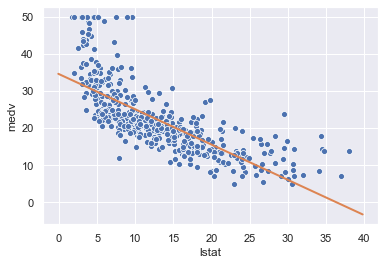

In [11]:
ax = sns.scatterplot(x='lstat', y='medv', data=boston)
xs = np.linspace(*ax.get_xlim(), 100)
ax.plot(xs, model_fit.predict({'lstat': xs}), color='C1', lw=2)
plt.show()

Note that we have modified the colour and width of the line. The colour name `C1` refers to the second colour in the default colour cycle. We highly recommend to stick to the colours in the default colour cycle; they were selected for good reasons!

#### Quick Regression Visualisation

If we are not interested in all the statistics and flexibility `statsmodels` provides, we can use `seaborn`'s built-in regression plot facility. This is useful to have a quick look but lacks a lot of the additional information provided by a fitted model. In particular, this does not allow us to compute predictions from future data sets.

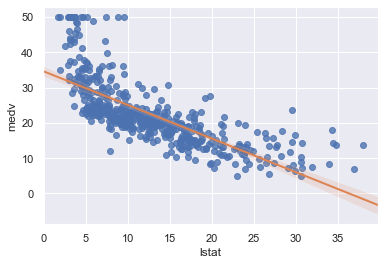

In [12]:
ax = sns.regplot(x='lstat', y='medv', data=boston,
                 line_kws={'color': 'C1', 'lw': 2})

Note that `seaborn` also draws the confidence interval around the predictions as a shaded area. We will look at how to retrieve this information from our fitted model next.

#### Residuals & Hat-values

We use the `get_influence()` method to get access to a host of useful quantities, including residuals, studentised residuals and hat-values.

In [13]:
influence = model_fit.get_influence()

Residuals:

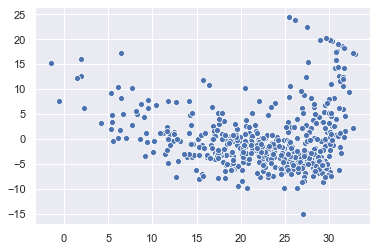

In [14]:
ax = sns.scatterplot(model_fit.predict(), influence.resid)

Studentised residuals:

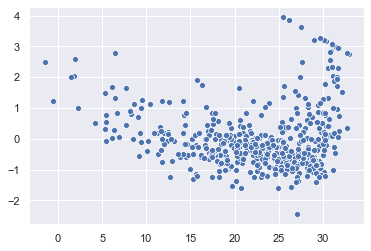

In [15]:
ax = sns.scatterplot(model_fit.predict(), influence.resid_studentized)

The residual plots suggest that there some non-linearity in the data. We can can get *leverage* statistics by accessing the `hat_matrix_diag` property of the `influence`.

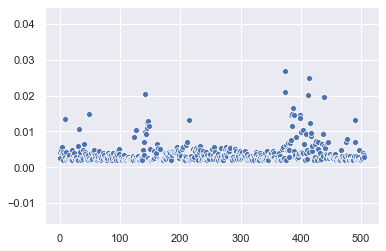

In [16]:
ax = sns.scatterplot(boston.index, influence.hat_matrix_diag)

In [17]:
influence.hat_matrix_diag.argmax()

374

The `argmax()` method of `numpy` arrays gives us the *index* of the maximum value in the array. In this case it tells us which *observation* has the largest leverage statistics.

#### Visualising the Fit Results with Confidence Interval Boundaries

Our goal is to make a graph with a scatter plot and overlay the line resulting from the fit together with the 95% confident interval boundary lines.

We recommend the following approach:

  - First use `seaborn` to produce the scatter plot.
  - Next get a range of predictor values from the plot's x-axis.
  - Then use the `matplotlib` `plot()` function to overlay the predicted curve of the fitted model.
  - Then use the `matplotlib` `fill_between()` function to overlay the confidence interval boundaries.
  
This approach does have the advantage that it works with *any* model! In particular, it works for the confidence interval boundaries, which are *not* straight lines.

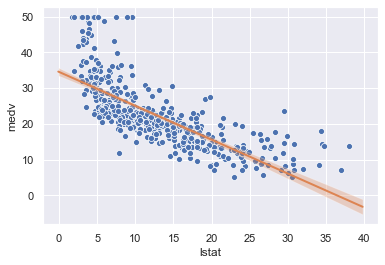

In [18]:
ax = sns.scatterplot(x='lstat', y='medv', data=boston)
xs = np.linspace(*ax.get_xlim(), 100)
pred = model_fit.get_prediction({'lstat': xs}).summary_frame()
ax.plot(xs, pred['mean'], color='C1', lw=2)
lower = pred['mean_ci_lower']
upper = pred['mean_ci_upper']
ax.fill_between(xs, lower, upper, alpha=0.3)
plt.show()

In [19]:
auto = datasets.Auto()
auto.set_index('name', inplace=True)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
model,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [20]:
formula = 'mpg~' + '+'.join(auto.columns.drop('mpg'))
lm = smf.ols(formula, auto).fit()

model
chevrolet chevelle malibu    2.999041
buick skylark 320            1.000701
plymouth satellite           2.759553
amc rebel sst                0.938094
ford torino                  2.032822
                               ...   
ford mustang gl             -1.319554
vw pickup                    9.535428
dodge rampage                0.863674
ford ranger                 -1.350244
chevy s-10                   2.271079
Length: 392, dtype: float64

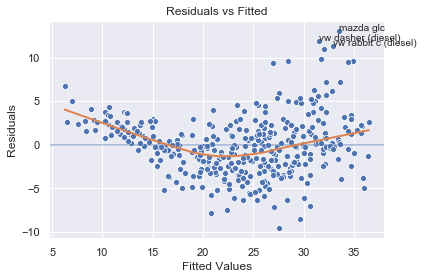

In [23]:
from islpy import lmplots
ax = lmplots.plot_resid(lm)

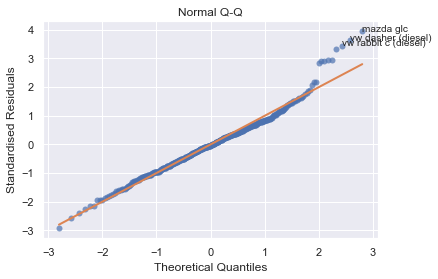

In [34]:
ax = lmplots.plot_qq(lm)

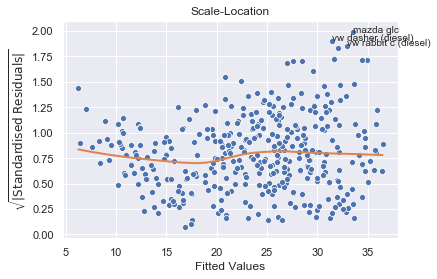

In [35]:
ax = lmplots.plot_scaleloc(lm)

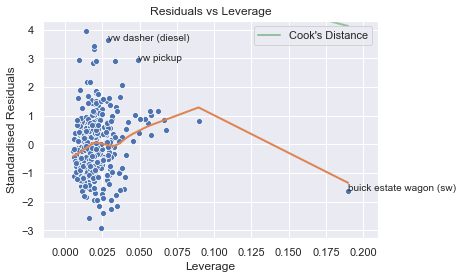

In [36]:
ax = lmplots.plot_leverage(lm)